# Pre-processing and Modelling

Notebook 3 of 4

## Preprocessing
We will import clean data, convert our text column into numerical values using either CountVectorizer or TF-IDF Vectorizer. 

In [1]:
# !pip install xgboost
# !pip install catboost

In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [3]:
# import dataset
combined_df = pd.read_csv("./datasets/combined_cleaned_reddit_selftext.csv")

## Data Summary

In [4]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4894 entries, 0 to 4996
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   subreddit               4894 non-null   int64 
 1   title_selftext          4894 non-null   object
 2   created_utc             4894 non-null   int64 
 3   stemmed_title_selftext  4894 non-null   object
dtypes: int64(2), object(2)
memory usage: 191.2+ KB


In [5]:
combined_df.head()

,subreddit,title_selftext,created_utc,stemmed_title_selftext
0,1,my coworker placing the hash browns like army ...,1663204910,cowork place hash brown like armi troopsface_w...
1,1,whats the deal with these? nan,1663196066,what deal
2,1,working for dunkin i know i asked about this b...,1663193081,work know i ask i curiou experi work dunkin wo...
3,1,how to make the ice tea ordered from door dash...,1663190691,make ice tea order door dash tast the ice tea ...
4,1,we still got 4 more hours of shift and this is...,1663185603,still got 4 hour shift we gotexploding_head


In [6]:
# check if there's any null value
combined_df[combined_df['stemmed_title_selftext']=='']

,subreddit,title_selftext,created_utc,stemmed_title_selftext


In [7]:
# rename the target variable
combined_df.rename({'subreddit':'is_dunkin'}, inplace=True, axis=1)

In [8]:
combined_df.head(3)

,is_dunkin,title_selftext,created_utc,stemmed_title_selftext
0,1,my coworker placing the hash browns like army ...,1663204910,cowork place hash brown like armi troopsface_w...
1,1,whats the deal with these? nan,1663196066,what deal
2,1,working for dunkin i know i asked about this b...,1663193081,work know i ask i curiou experi work dunkin wo...


## Train-Test-Split
Holdout 25% of sample data not to be exposed to any fitting from the modeling. Then we generate predictions against this holdout data.

In [9]:
X = combined_df['stemmed_title_selftext']
y = combined_df['is_dunkin']

In [10]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

In [11]:
# ratio of target variable
combined_df['is_dunkin'].value_counts(normalize=True)

0    0.501839
1    0.498161
Name: is_dunkin, dtype: float64

Target variable is very balanced dataset with almost equal number of Starbucks and Dunkin Donuts.

## Modeling
Our target variable is in binary value, this is a binary classification problem. We will evaluate the classification models to get the best model. In previous notebook, we have defined our null/ baseline model to be the value of majority class. As the first model, we will go with Naive Bayes model after performing CountVectorizer and compare other models against the baseline. 

The proportion of target variables is balanced. Therefore, accuracy is the selected metric to evaluate our models. Moreover, in this context, the consequences of False Positives and False Negatives are equally same. Our goal is to accurately categorise both Starbucks and Dunkin Donuts titles. 

### Naive Bayes model

#### CountVectorizer
Perform GridSearch over a count vectorizer and Multinomial Naive Bayes model since our features are integer values.

In [12]:
pipe_nb = Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

In [13]:
pipe_nb.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [14]:
pipe_nb_params = {'cvec__max_features':[500,1000,2000], 'cvec__stop_words':['english'], 'cvec__min_df':[0.001,0.002,0.005], 'cvec__ngram_range':[(1,1),(2,2),(1,2)]}

In [15]:
gs_nb = GridSearchCV(pipe_nb, param_grid=pipe_nb_params, cv=5)

In [16]:
gs_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_features': [500, 1000, 2000],
                         'cvec__min_df': [0.001, 0.002, 0.005],
                         'cvec__ngram_range': [(1, 1), (2, 2), (1, 2)],
                         'cvec__stop_words': ['english']})

In [17]:
gs_nb.best_score_

0.7751824817518249

In [18]:
pd.DataFrame(gs_nb.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__min_df,param_cvec__ngram_range,param_cvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
23,0.236925,0.031614,0.041545,0.015340,2000,0.002,"(1, 2)",english,"{'cvec__max_features': 2000, 'cvec__min_df': 0...",0.748905,0.776642,0.775182,0.782482,0.792701,0.775182,0.014511,1
18,0.081119,0.000780,0.016522,0.000470,2000,0.001,"(1, 1)",english,"{'cvec__max_features': 2000, 'cvec__min_df': 0...",0.751825,0.775182,0.770803,0.786861,0.791241,0.775182,0.013849,2
20,0.251038,0.018454,0.026027,0.007874,2000,0.001,"(1, 2)",english,"{'cvec__max_features': 2000, 'cvec__min_df': 0...",0.747445,0.773723,0.776642,0.778102,0.795620,0.774307,0.015466,3


In [19]:
gs_nb.score(X_train, y_train)

0.8236496350364964

In [20]:
gs_nb.score(X_test, y_test)

0.7814840027229408

In [21]:
y_pred = gs_nb.predict(X_test)

In [22]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

568 169 152 580


In [23]:
cm = confusion_matrix(y_test, y_pred)

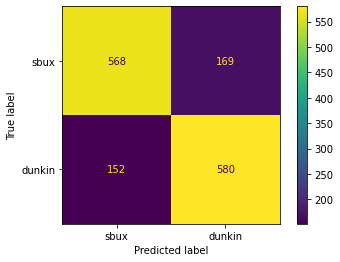

In [24]:
# visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['sbux', 'dunkin'])
disp.plot()
plt.show();

Naive Bayes model has accuracy score of about 0.80. The scores for train set is slightly higher than that for test set, indicating slight overfitting. 

### Find the best models using PyCaret
We will use PyCaret Library to get the best model.

In [25]:
from pycaret.classification import *

#### TF-IDF
I will use TF-IDF vectorizer for my model as it is more robust, looking at both frequencies of the words but also the importance of the word relative to other documents in the corpus. This will reduce the effects of words that are frequent in both Starbucks and Dunkin donuts subreddit but has no predictive power. As seen in EDA section, some top words appear in both documents. 

I will proceed with a unigram and bigram bag of words. From our EDA section, many of the top drinks and ingredients of each brand appear in our top bigram.

In [26]:
tfvec = TfidfVectorizer(min_df = 0.001, max_features = 2000, ngram_range = (1,2)) # add stop_words?

In [27]:
X_train_tfvec = pd.DataFrame(tfvec.fit_transform(X_train.values).todense(), columns = tfvec.get_feature_names_out())

In [28]:
# transform the test data
X_test_tfvec = pd.DataFrame(tfvec.transform(X_test.values).todense(), columns = tfvec.get_feature_names_out())

### Model Comparison

In [29]:
pyca_df = pd.concat([X_train_tfvec, y_train.reset_index(drop = True)], axis = 1)
pyca_df.shape

(3425, 2001)

In [30]:
pyca_df.to_csv('./datasets/pyca_df.csv', index=False )

In [31]:
pyca_df.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you have,you know,you like,you order,you re,you to,you want,your,zero,is_dunkin
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0
1,0.0,0.0,0.0,0.154588,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183837,0
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1


In [32]:
numeric_cols = [(pyca_df.columns)]
numeric_cols = numeric_cols[:-1]

### Setup PyCaret for Model Comparison
This is the first step we recommend in any supervised machine learning task. This function trains all the models in the model library using default hyperparameters and evaluates performance metrics using cross validation. It returns the trained model object class. The evaluation metrics for Classification: Accuracy, AUC, Recall, Precision, F1, Kappa, MCC.


In [33]:
# init setup
pyca_model = setup(data = pyca_df, numeric_features = numeric_cols, target = 'is_dunkin', session_id = 728 )

,Description,Value
0,Session id,728
1,Target,is_dunkin
2,Target type,Binary
3,Original data shape,"(3425, 2001)"
4,Transformed data shape,"(3425, 2001)"
5,Transformed train set shape,"(2397, 2001)"
6,Transformed test set shape,"(1028, 2001)"
7,Numeric features,2000
8,Preprocess,True
9,Imputation type,simple


In [34]:
# return best model
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7722,0.8535,0.7553,0.7808,0.7672,0.5443,0.5454,1.0720
gbc,Gradient Boosting Classifier,0.7580,0.8542,0.6851,0.8025,0.7379,0.5157,0.5225,2.2340
et,Extra Trees Classifier,0.7576,0.8314,0.7487,0.7619,0.7548,0.5152,0.5159,1.0060
ridge,Ridge Classifier,0.7547,0.0000,0.7479,0.7571,0.7519,0.5093,0.5101,0.2310
rf,Random Forest Classifier,0.7447,0.8351,0.7521,0.7406,0.7457,0.4893,0.4902,0.6790
svm,SVM - Linear Kernel,0.7376,0.0000,0.7227,0.7442,0.7325,0.4750,0.4762,0.2950
ada,Ada Boost Classifier,0.7247,0.8278,0.5930,0.8026,0.6809,0.4488,0.4653,0.7020
nb,Naive Bayes,0.7234,0.7370,0.7696,0.7032,0.7347,0.4469,0.4492,0.1940
lightgbm,Light Gradient Boosting Machine,0.7230,0.8145,0.7151,0.7259,0.7193,0.4458,0.4472,0.4980
dt,Decision Tree Classifier,0.6984,0.7130,0.7010,0.6971,0.6985,0.3967,0.3973,0.3700


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

In [35]:
# return best model
top5 = compare_models(n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7722,0.8535,0.7553,0.7808,0.7672,0.5443,0.5454,0.3300
gbc,Gradient Boosting Classifier,0.7580,0.8542,0.6851,0.8025,0.7379,0.5157,0.5225,2.0190
et,Extra Trees Classifier,0.7576,0.8314,0.7487,0.7619,0.7548,0.5152,0.5159,0.9000
ridge,Ridge Classifier,0.7547,0.0000,0.7479,0.7571,0.7519,0.5093,0.5101,0.2080
rf,Random Forest Classifier,0.7447,0.8351,0.7521,0.7406,0.7457,0.4893,0.4902,0.6380
svm,SVM - Linear Kernel,0.7376,0.0000,0.7227,0.7442,0.7325,0.4750,0.4762,0.2550
ada,Ada Boost Classifier,0.7247,0.8278,0.5930,0.8026,0.6809,0.4488,0.4653,0.6880
nb,Naive Bayes,0.7234,0.7370,0.7696,0.7032,0.7347,0.4469,0.4492,0.2180
lightgbm,Light Gradient Boosting Machine,0.7230,0.8145,0.7151,0.7259,0.7193,0.4458,0.4472,0.3200
dt,Decision Tree Classifier,0.6984,0.7130,0.7010,0.6971,0.6985,0.3967,0.3973,0.3630


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Models to evaluate
- Logistic Regression
- Random Forest
- Gradient Boosting
- Support Vector Machine

Extra Trees Classifier is too similar to Random Forest Model, while Ridge Classifier is similar to Logistic Regression, so we will not evaluate two of them. 

### Create Model
While compare_models() is a powerful function and often a starting point in any experiment, it does not return any trained models. create_model() function creates a model and scores it using stratified cross validation.

In [36]:
# train logistic regression
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7708,0.8374,0.7833,0.7642,0.7737,0.5417,0.5418
1,0.8375,0.8988,0.8417,0.8347,0.8382,0.6750,0.6750
2,0.7875,0.8540,0.8250,0.7674,0.7952,0.5750,0.5766
3,0.7542,0.8190,0.7167,0.7748,0.7446,0.5083,0.5098
4,0.7375,0.8313,0.7395,0.7333,0.7364,0.4750,0.4750
5,0.7708,0.8559,0.7143,0.8019,0.7556,0.5412,0.5444
6,0.8125,0.8881,0.7899,0.8246,0.8069,0.6248,0.6254
7,0.7322,0.8377,0.6975,0.7477,0.7217,0.4643,0.4653
8,0.7908,0.8637,0.7395,0.8224,0.7788,0.5814,0.5844


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [37]:
# test logistic regression on holdout set
lr = create_model('lr', cross_validation = False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.7763,0.8614,0.7656,0.7809,0.7732,0.5525,0.5526


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
# train Random Forest
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6958,0.8029,0.7333,0.6822,0.7068,0.3917,0.3928
1,0.7958,0.8875,0.8250,0.7795,0.8016,0.5917,0.5927
2,0.7500,0.8419,0.7917,0.7308,0.7600,0.5000,0.5017
3,0.7083,0.8074,0.6917,0.7155,0.7034,0.4167,0.4169
4,0.7292,0.8229,0.7311,0.7250,0.7280,0.4583,0.4583
5,0.7625,0.8494,0.7479,0.7672,0.7574,0.5249,0.5250
6,0.7750,0.8730,0.7815,0.7686,0.7750,0.5500,0.5501
7,0.7322,0.8160,0.7815,0.7099,0.7440,0.4647,0.4670
8,0.7490,0.8193,0.7059,0.7706,0.7368,0.4977,0.4995


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [39]:
# train Support Vector Machine
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7042,0.0000,0.7167,0.6992,0.7078,0.4083,0.4085
1,0.7583,0.0000,0.7833,0.7460,0.7642,0.5167,0.5173
2,0.7875,0.0000,0.8167,0.7717,0.7935,0.5750,0.5760
3,0.7167,0.0000,0.6750,0.7364,0.7043,0.4333,0.4348
4,0.7125,0.0000,0.7143,0.7083,0.7113,0.4250,0.4250
5,0.7417,0.0000,0.7059,0.7568,0.7304,0.4830,0.4841
6,0.7792,0.0000,0.7395,0.8000,0.7686,0.5580,0.5596
7,0.6946,0.0000,0.6975,0.6917,0.6946,0.3891,0.3891
8,0.7573,0.0000,0.7227,0.7748,0.7478,0.5145,0.5157


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [40]:
# train Gradient Boosting
gbc = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7167,0.8051,0.6667,0.7407,0.7018,0.4333,0.4355
1,0.7917,0.8830,0.7000,0.8571,0.7706,0.5833,0.5934
2,0.7667,0.8808,0.7583,0.7712,0.7647,0.5333,0.5334
3,0.7500,0.8147,0.6583,0.8061,0.7248,0.5000,0.5086
4,0.7625,0.8660,0.6975,0.7981,0.7444,0.5245,0.5286
5,0.7583,0.8594,0.6050,0.8675,0.7129,0.5154,0.5404
6,0.8083,0.8909,0.7479,0.8476,0.7946,0.6163,0.6205
7,0.7197,0.8170,0.6471,0.7549,0.6968,0.4390,0.4435
8,0.7406,0.8612,0.6639,0.7822,0.7182,0.4808,0.4864


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

### Tune Model Hyperparameter
This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using stratified cross validation.

In [41]:
# tune lr model
tuned_lr = tune_model(lr, choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7583,0.8351,0.7667,0.7541,0.7603,0.5167,0.5167
1,0.8292,0.8956,0.8250,0.8319,0.8285,0.6583,0.6584
2,0.7875,0.8476,0.8167,0.7717,0.7935,0.5750,0.5760
3,0.7583,0.8177,0.7250,0.7768,0.7500,0.5167,0.5178
4,0.7375,0.8278,0.7395,0.7333,0.7364,0.4750,0.4750
5,0.7708,0.8549,0.7227,0.7963,0.7577,0.5413,0.5436
6,0.8042,0.8865,0.7815,0.8158,0.7983,0.6082,0.6087
7,0.7322,0.8367,0.6975,0.7477,0.7217,0.4643,0.4653
8,0.7950,0.8622,0.7479,0.8241,0.7841,0.5898,0.5923


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Tuning lr model reduces Accuracy score from 0.7722 to 0.7697, this depicts that tuning has adverse effect/ ineffective/ not useful.

In [42]:
# tune rf model
tuned_rf = tune_model(rf, choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7042,0.7946,0.8500,0.6581,0.7418,0.4083,0.4269
1,0.7250,0.8197,0.8167,0.6901,0.7481,0.4500,0.4578
2,0.7125,0.8173,0.8417,0.6689,0.7454,0.4250,0.4399
3,0.6958,0.7905,0.8500,0.6497,0.7365,0.3917,0.4117
4,0.7292,0.8041,0.8151,0.6929,0.7490,0.4591,0.4663
5,0.7542,0.8503,0.8571,0.7083,0.7757,0.5092,0.5205
6,0.7417,0.8427,0.8655,0.6913,0.7687,0.4844,0.5002
7,0.7029,0.8075,0.8739,0.6500,0.7455,0.4067,0.4329
8,0.6820,0.8076,0.8151,0.6424,0.7185,0.3647,0.3785


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Tuning rf model reduces Accuracy score from 0.7447 to 0.7142, this depicts that tuning has adverse effect/ ineffective/ not improving.

In [43]:
# tune svm model
tuned_svm = tune_model(svm, choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7208,0.0000,0.7500,0.7087,0.7287,0.4417,0.4424
1,0.8333,0.0000,0.8250,0.8390,0.8319,0.6667,0.6668
2,0.7792,0.0000,0.7833,0.7769,0.7801,0.5583,0.5584
3,0.7333,0.0000,0.6833,0.7593,0.7193,0.4667,0.4690
4,0.7417,0.0000,0.7227,0.7478,0.7350,0.4832,0.4834
5,0.7375,0.0000,0.6555,0.7800,0.7123,0.4743,0.4803
6,0.7917,0.0000,0.7731,0.8000,0.7863,0.5832,0.5835
7,0.7280,0.0000,0.6975,0.7411,0.7186,0.4559,0.4567
8,0.7741,0.0000,0.7479,0.7876,0.7672,0.5480,0.5487


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Tuning svm model improves Accuracy score from 0.7376 to 0.7605, this depicts that tuning has slight positive effect.

In [44]:
# tune gbc model
tuned_gbc = tune_model(gbc, choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7583,0.8297,0.7833,0.7460,0.7642,0.5167,0.5173
1,0.8000,0.8910,0.7750,0.8158,0.7949,0.6000,0.6008
2,0.7417,0.8441,0.7500,0.7377,0.7438,0.4833,0.4834
3,0.7250,0.8044,0.7000,0.7368,0.7179,0.4500,0.4506
4,0.7208,0.8219,0.7143,0.7203,0.7173,0.4416,0.4416
5,0.7542,0.8590,0.6639,0.8061,0.7281,0.5076,0.5156
6,0.7750,0.8761,0.7563,0.7826,0.7692,0.5498,0.5501
7,0.7155,0.8116,0.7899,0.6861,0.7344,0.4313,0.4363
8,0.7406,0.8453,0.7563,0.7317,0.7438,0.4812,0.4815


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Tuning gbc model reduces Accuracy score from 0.7580 to 0.7488, this depicts that tuning has nadverse effect/ ineffective/ noy useful.

### Plot Model
Before model finalization, the plot_model() function can be used to analyze the performance across different aspects. This function takes a trained model object and returns a plot based on the test / hold-out set.

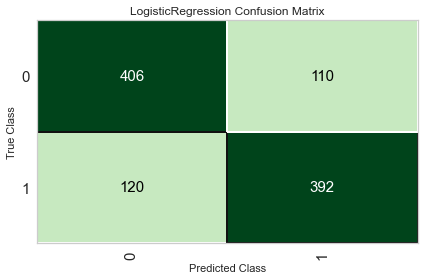

In [45]:
plot_model(tuned_lr, plot = 'confusion_matrix')

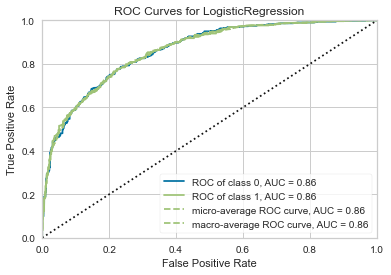

In [46]:
plot_model(tuned_lr, plot = 'auc')

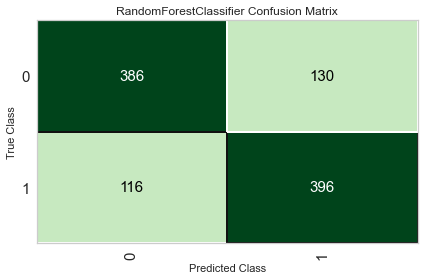

In [47]:
plot_model(tuned_rf, plot = 'confusion_matrix')

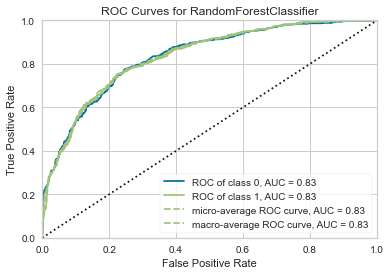

In [48]:
plot_model(tuned_rf, plot = 'auc')

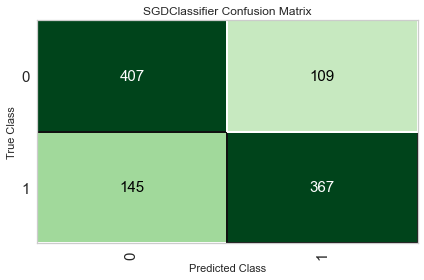

In [49]:
plot_model(tuned_svm, plot = 'confusion_matrix')

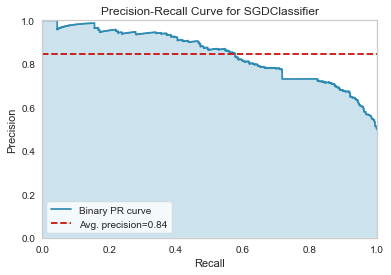

In [50]:
plot_model(tuned_svm, plot = 'pr')

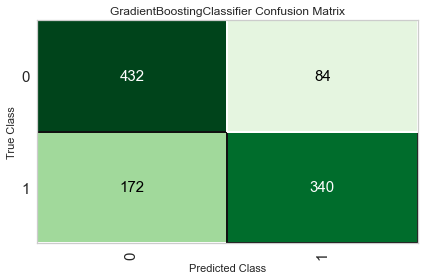

In [51]:
plot_model(tuned_gbc, plot = 'confusion_matrix')

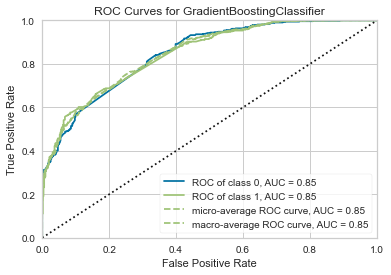

In [52]:
plot_model(tuned_gbc,plot = 'auc')

In [53]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [54]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [55]:
evaluate_model(tuned_svm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [56]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

### Predict on test / hold-out Sample set
Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics.

All of the evaluation metrics we have seen above are cross validated results based on the training set (70%) only. Now, using our final trained model stored in the tuned variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [57]:
predict_model(tuned_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7763,0.8614,0.7656,0.7809,0.7732,0.5525,0.5526


,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.7511
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.6255
2399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183793,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6958
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6258
2401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.5838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8376
3421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.8456
3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6425
3423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.218345,0.0,0.0,0.0,0.0,0.0,1,1,0.5637


In [58]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7607,0.8334,0.7734,0.7529,0.7630,0.5214,0.5216


,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8800
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.7900
2399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183793,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6691
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6300
2401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.5292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9267
3421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.9200
3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.6500
3423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.218345,0.0,0.0,0.0,0.0,0.0,1,1,0.6000


In [59]:
predict_model(tuned_svm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7529,0.7528,0.7168,0.7710,0.7429,0.5057,0.5069


,10,100,11,12,13,15,16,17,18,20,...,you know,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
2399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183793,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
2401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
3421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1
3423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.218345,0.0,0.0,0.0,0.0,0.0,1,0


In [60]:
predict_model(tuned_gbc)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7510,0.8467,0.6641,0.8019,0.7265,0.5016,0.5091


,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
2397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.9341
2398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.8927
2399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183793,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8471
2400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.5635
2401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,0,0.5506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8159
3421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,0,0.8961
3422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0.8292
3423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.218345,0.0,0.0,0.0,0.0,0.0,1,1,0.6258


### Predict on test / hold-out Sample set
|Model|LogisticsRegression|Randm Forest|Support Vector Machine|Gradient Boosting Classifier|  
|---|---|---|---|---|
|Accuracy| 0.7763 | 0.7607 | 0.7529 | 0.7510 |

## Finalize Model
This function trains a given estimator on the entire dataset including the holdout set. The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

Caution: One final word of caution. Once the model is finalized using finalize_model(), the entire dataset including the test/hold-out set is used for training. As such, if the model is used for predictions on the hold-out set after finalize_model() is used, the information grid printed will be **misleading** as you are trying to predict on the same data that was used for modeling.

In [61]:
# print final Logistic Regression model parameters for deployment
final_lr = finalize_model(tuned_lr)
print(final_lr)

Pipeline(memory=Memory(location=C:\Users\yuner\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['10', '100', '11', '12', '13',
                                             '15', '16', '17', '18', '20',
                                             '2021', '2022', '30', '40', '400',
                                             '50', 'abl', 'abl to', 'about',
                                             'about the', 'about thi',
                                             'absolut', 'accept', 'access',
                                             'accident', 'account', 'across',
                                             'act', 'action', 'act...
                 TransformerWrapper(exclude=[], include=None,
                                    transformer=VarianceThreshold(threshold=0))),
                ('actual_estimator',
                 LogisticRegression(C=1.0, class_weig

In [62]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

Pipeline(memory=Memory(location=C:\Users\yuner\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['10', '100', '11', '12', '13',
                                             '15', '16', '17', '18', '20',
                                             '2021', '2022', '30', '40', '400',
                                             '50', 'abl', 'abl to', 'about',
                                             'about the', 'about thi',
                                             'absolut', 'accept', 'access',
                                             'accident', 'account', 'across',
                                             'act', 'action', 'act...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
         

In [63]:
final_svm = finalize_model(tuned_svm)
print(final_svm)

Pipeline(memory=Memory(location=C:\Users\yuner\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['10', '100', '11', '12', '13',
                                             '15', '16', '17', '18', '20',
                                             '2021', '2022', '30', '40', '400',
                                             '50', 'abl', 'abl to', 'about',
                                             'about the', 'about thi',
                                             'absolut', 'accept', 'access',
                                             'accident', 'account', 'across',
                                             'act', 'action', 'act...
                 SGDClassifier(alpha=0.001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.001,
                               fit_intercept=False, l1_ratio=0.7400000001,
   

In [64]:
final_gbc = finalize_model(tuned_gbc)
print(final_gbc)

Pipeline(memory=Memory(location=C:\Users\yuner\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['10', '100', '11', '12', '13',
                                             '15', '16', '17', '18', '20',
                                             '2021', '2022', '30', '40', '400',
                                             '50', 'abl', 'abl to', 'about',
                                             'about the', 'about thi',
                                             'absolut', 'accept', 'access',
                                             'accident', 'account', 'across',
                                             'act', 'action', 'act...
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=Non

### Predict against unseen data

In [65]:
unseen_df = pd.concat([X_test_tfvec, y_test.reset_index(drop = True)], axis = 1)
unseen_df.shape

(1469, 2001)

In [66]:
unseen_df.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you have,you know,you like,you order,you re,you to,you want,your,zero,is_dunkin
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Logistic Regression

In [67]:
lr_pred = predict_model(final_lr, data = unseen_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7808,0.8728,0.7637,0.7895,0.7764,0.5616,0.5619


In [68]:
lr_pred.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0.5123
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6583
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8055


### Random Forest

In [69]:
rf_pred = predict_model(final_rf, data = unseen_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7726,0.8568,0.7555,0.7811,0.7681,0.5452,0.5455


In [70]:
rf_pred.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5332
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.5140
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9000


### Support Vector Machine

In [71]:
svm_pred = predict_model(final_svm, data = unseen_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7502,0.7501,0.7158,0.7672,0.7406,0.5002,0.5013


In [72]:
svm_pred.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you know,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


### Gradient Boosting Classifier

In [73]:
gbc_pred = predict_model(final_gbc, data = unseen_df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7611,0.8669,0.6885,0.8038,0.7417,0.5219,0.5273


In [74]:
gbc_pred.head(3)

,10,100,11,12,13,15,16,17,18,20,...,you like,you order,you re,you to,you want,your,zero,is_dunkin,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.5094
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.5005
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9688


## Model Evaluation
Score Summary 

|Model|Logistic Regression|Random Forest Classifier|Support Vector Machine|Gradient Boosting Classifier|
|---|---|---|---|---|
| CV score | 0.7722 | 0.7447 | 0.7378 | 0.7580 |
| Train score | 0.7763 | 0.7607 | 0.7529 | 0.7510 | 
| Test score | 0.7808 | 0.7726 | 0.7502 | 0.7611 |	


From our results, Logistic Regression gives the best accurary of 0.78. This means that 78% of the future posts are likely to be classified correctly. A Logistic Regression is an effective model for a binary classification problem. It predicts the target variable by taking in a linear combination of the features as the input. It calculates the probability of the target outcome for each document using the log-odds. The only caveat is that Logistic Regression assumes that the features are independent variables which is likely to be violates in this scenario as the words are likely to be dependent due to the nature of languages.

All models does not show any sign of overfitting, as there is not a significant difference. The result is much better than the accuracy of baseline model (0.50). Generally, metrics alone are not the only criteria we should consider when finalizing the best model for production. Other factors to consider include training time, standard deviation of kfolds etc. A Logistic Regression is computationally inexpensive compared to Random Forest, Support Vector Machine and Gradient Boosting. Besides, Logistic Regression is easy to interpret. 

In summary, Logistic Regression is the best model.